**Mini-Project I: Where do I book an accomodation?**

In [4]:
# importing necessary libraries
import re
import time
import json
import requests
import datetime
import traceback
import pandas as pd
from bs4 import BeautifulSoup


**Step 1: Webscraping** </br>


In [5]:
# installing python selenium package and chrome-driver
!pip install selenium
!apt-get update 
!apt install chromium-chromedriver

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 985 kB 3.9 MB/s 
     |████████████████████████████████| 358 kB 49.4 MB/s 
     |████████████████████████████████| 140 kB 49.2 MB/s 
     |████████████████████████████████| 58 kB 6.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.12 which is incompatible.


Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,545 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://se

In [7]:
# importing necessary modules from selenium
# setting up the web driver
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--disable-blink-features=AutomationControlled')

user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36"
chrome_options.add_argument('user-agent={0}'.format(user_agent))
driver = webdriver.Chrome('chromedriver', options=chrome_options)
driver.set_window_size(1080,800)
driver.maximize_window()

In [6]:
# pre-set values
country = 'England'
city = "London"
count = 1
currency = "EUR"
check_in_date = "2022-11-10"
check_out_date = "2022-11-11"
request_header = {
    "Content-Type": "text/html",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36"
}

In [8]:
# 1. Booking.com

# information gotten from looking into the website
rows_per_page = 25
base_url = "https://www.booking.com"

# changing the check in and check out date to datetime formats
date_in = datetime.datetime.strptime(check_in_date, "%Y-%m-%d")
date_out = datetime.datetime.strptime(check_out_date, "%Y-%m-%d")

"""
getting the top 50 hotels from the search results
since each page shows 25 search results, pagination can be used to access the
next set of 25 resuts
after checking the request URL for booking.com, I noticed that the rows per page
were set in the offset value together with the other values in the request parameters
"""
booking_hotel_data = []
for i in range(2):
    url_with_filters = f"{base_url}/searchresults.en-gb.html?checkin_month={date_in.month}" \
        f"&checkin_monthday={date_in.day}&checkin_year={date_in.year}&checkout_month={date_out.month}" \
        f"&checkout_monthday={date_out.day}&checkout_year={date_out.year}&group_adults={count}" \
        f"&group_children=0&order=price&ss={city}%2C%20{country}&offset={rows_per_page*i}"\

    print(url_with_filters)
    driver.get(url_with_filters)

    # using the web driver to change the currency to Euro
    currency_element = driver.find_element(By.CSS_SELECTOR,
        'button[data-tooltip-text="Choose your currency"]'
    )
    currency_element.click()
    time.sleep(2)
    selected_currency_element = driver.find_element(By.CSS_SELECTOR,
        'a[data-modal-header-async-url-param="changed_currency=1&selected_currency=EUR"]'
    )
    selected_currency_element.click()
    time.sleep(5)

    # using BeautifulSoup to parse the page source
    soup = BeautifulSoup(driver.page_source, "lxml")

    # getting the hotel details from search results
    hotels = soup.select('div[data-testid="property-card"]')

    for hotel in hotels:
        hotel_datum = {}
        # for name
        hotel_datum["hotel_name"] = hotel.select_one('div[data-testid="title"]').text.strip()
        hotel_link = hotel.find('a')['href']
        # for hotel address
        hotel_datum["hotel_address"] = hotel.select_one('div[data-testid="location"]').select_one('span[data-testid="address"]').text.strip()
        # for distance from the center
        hotel_datum["distance_from_center"] = hotel.select_one('div[data-testid="location"]').select_one('span[data-testid="distance"]').text.strip()
        # for review score
        hotel_datum["review_score"] = hotel.select_one('div[data-testid="review-score"]').find_all('div')[0].text.strip()
        # for number of stars
        hotel_datum["number_of_stars"] = 0
        rating_stars_present = hotel.select_one('div[data-testid="rating-stars"]')
        if rating_stars_present:
            hotel_datum["number_of_stars"] = len(rating_stars_present.find_all('span'))
        # for total price
        hotel_datum["total_price"] = hotel.select_one('div[data-testid="price-and-discounted-price"]').find_all('span')[-1].text.strip()
        # for total nights
        hotel_datum["total_nights"] = hotel.select_one('div[data-testid="price-for-x-nights"]').text.strip()

        # using the hotel link to go to the webpage for the specific hotel to get additional details
        hotel_source = requests.get(hotel_link, headers=request_header)
        hotel_soup = BeautifulSoup(hotel_source.text, 'lxml')

        hotel_datum['hotel_link'] = hotel_link
        # for hotel description
        hotel_datum["hotel_summary"] = hotel_soup.find('div', {"id": "property_description_content"}).text.strip()

        # for images
        hotel_images = []
        image_count = 0
        for a_tag in hotel_soup.find_all('a', {"class": "bh-photo-grid-item bh-photo-grid-photo1 active-image "}):
            if image_count == 7:
                break
            hotel_images.append(a_tag.find('img')['src'])
            image_count += 1
            
        for a_tag in hotel_soup.find_all('a', {"class": "bh-photo-grid-item bh-photo-grid-thumb"}):
            if image_count == 7:
                break
            hotel_images.append(a_tag.find('img')['src'])
            image_count += 1

        hotel_datum['images'] = str(hotel_images)
        hotel_datum['source'] = "booking.com"
        booking_hotel_data.append(hotel_datum)
        
print(len(booking_hotel_data))
# saving the data in a Pandas dataframe
booking_df = pd.DataFrame(booking_hotel_data)
print(booking_df.head())
driver.quit()

https://www.booking.com/searchresults.en-gb.html?checkin_month=11&checkin_monthday=10&checkin_year=2022&checkout_month=11&checkout_monthday=11&checkout_year=2022&group_adults=1&group_children=0&order=price&ss=London%2C%20England&offset=0
https://www.booking.com/searchresults.en-gb.html?checkin_month=11&checkin_monthday=10&checkin_year=2022&checkout_month=11&checkout_monthday=11&checkout_year=2022&group_adults=1&group_children=0&order=price&ss=London%2C%20England&offset=25
50
                    hotel_name                   hotel_address  \
0  Smart Russell Square Hostel                  Camden, London   
1     Kensal Green Backpackers  Kensington and Chelsea, London   
2  Smart Hyde Park View Hostel     Westminster Borough, London   
3           Book A Bed Hostels                Lewisham, London   
4   Smart Hyde Park Inn Hostel     Westminster Borough, London   

    distance_from_center review_score  number_of_stars total_price  \
0  1.1 miles from centre          6.8                

In [49]:
# 2. Expedia.fi

driver = webdriver.Chrome('chromedriver', options=chrome_options)
driver.set_window_size(1080,800)
driver.maximize_window()
base_url = "https://www.expedia.fi"
url_with_parameters = f"{base_url}/Hotel-Search?destination={city}&startDate={check_in_date}&endDate={check_out_date}&d1={check_in_date}&d2={check_out_date}&rooms={count}&adults={count}&regionId=178279&latLong=51.507538%2C-0.127804&sort=DISTANCE"
# waiting for all the data to be loaded
driver.implicitly_wait(10)
driver.get(url_with_parameters)
# clicking the "Show more" button to get more search results
element = driver.find_element(By.CLASS_NAME, 'uitk-button.uitk-button-medium.uitk-button-secondary')
driver.execute_script("arguments[0].click();", element)
time.sleep(10)

soup = BeautifulSoup(driver.page_source, "lxml")
hotels = soup.select('section[data-stid="section-results"]')[0].find_all('li', {"class": "uitk-spacing uitk-spacing-margin-blockstart-three"})

# added this so that if the search results loaded are still less than 50, 
# the button will be clicked again to load more results
while len(hotels) < 51:
    element = driver.find_element(By.CLASS_NAME, 'uitk-button.uitk-button-medium.uitk-button-secondary')
    driver.execute_script("arguments[0].click();", element)
    time.sleep(10)
    soup = BeautifulSoup(driver.page_source, "lxml")
    hotels = soup.select('section[data-stid="section-results"]')[0].find_all('li', {"class": "uitk-spacing uitk-spacing-margin-blockstart-three"})

expedia_hotel_data = []
for hotel in hotels:
    hotel_datum = {}
    # for name
    hotel_datum['hotel_name'] = hotel.find_all('div', {"class": "uitk-card-content-section"})[0].find('h2', {"class": "uitk-heading"}).text.strip()
    # for distance from center
    hotel_datum['distance_from_center'] = hotel.find_all('div', {"class": "uitk-card-content-section"})[0].find('div', {"class": "uitk-text"}).text.strip()
    # for hotel address
    hotel_datum['hotel_address'] = hotel.find_all('div', {"class": "uitk-text"})[0].text.strip()
    # for total price
    hotel_datum['total_price'] = hotel.find_all('div', {"class": "uitk-text uitk-type-600 uitk-type-bold uitk-text-emphasis-theme"})[0].text.strip()
    # for total nights
    hotel_datum['total_nights'] = 1
    # for hotel link
    hotel_datum['hotel_link'] = "https://www.expedia.com" + '/' + hotel.select('a[data-stid="open-hotel-information"]')[0]['href']
    driver.implicitly_wait(20)
    # for accessing the webpage with the details from specific hotel
    driver.get(hotel_datum["hotel_link"])

    try:
        element = WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.CLASS_NAME, 'uitk-spacing-margin-block-six')))
        driver.execute_script("arguments[0].scrollIntoView();", element)
        driver.find_element(By.LINK_TEXT, "Location").click();
        time.sleep(10)
        hotel_soup = BeautifulSoup(driver.page_source, "html.parser")
        # for images
        images = []
        image_links = hotel_soup.find_all("div", {"class": "uitk-layout-grid uitk-layout-grid-has-columns uitk-layout-grid-has-rows uitk-layout-grid-has-space uitk-layout-grid-display-grid"})[0].find_all("div", {"class": "uitk-image-placeholder"})
        for figure in image_links:
            images.append(figure.find("img")['src'])
        hotel_datum["images"] = str(images)
        
        # for review score
        hotel_datum['review_score'] = hotel_soup.select('div[data-stid="content-hotel-reviewsummary"]')[0].text.strip().split('/')[0]

        # for number of stars
        hotel_datum['number_of_stars'] = len(hotel_soup.find_all('div', {"class": "uitk-rating"})[0].find_all('svg'))
        
        # for hotel description
        summary_text = hotel_soup.select('div[data-stid="content-markup"]')
        hotel_summary = ""
        for text in summary_text:
            hotel_summary = hotel_summary + text.text.strip()
        hotel_datum['hotel_summary'] = hotel_summary
        hotel_datum['source'] = 'expedia.fi'

    except:
        print(traceback.format_exc())

    expedia_hotel_data.append(hotel_datum)
    if len(expedia_hotel_data) == 50:
        break

print(len(expedia_hotel_data))
# saving the data into a Pandas dataframe
expedia_hotels_df = pd.DataFrame(expedia_hotel_data)
expedia_hotels_df.head()

# quitting the web driver
driver.quit()

50


In [50]:
# OneTravel.com

# for starting the web driver
driver = webdriver.Chrome('chromedriver', options=chrome_options)
driver.set_window_size(1080,800)
driver.maximize_window()

one_travel_url_with_parameters = "https://book.onetravel.com/searchresults.html?aid=1545322&label=desktop-1545322-click&sid=77942ee310186c10a5c8e873bab5557b&tmpl=searchresults&checkin_month=11;checkin_monthday=10;checkin_year=2022;checkout_month=11;checkout_monthday=11;checkout_year=2022;class_interval=1;group_adults=1;group_children=0;label_click=undef;no_rooms=1;offset=0;room1=A;sb_price_type=total;shw_aparth=1;slp_r_match=0;srpvid=d8d15b3f25fa02dd;ss=London;ssb=empty&&selected_currency=EUR"

date_in = datetime.datetime.strptime(check_in_date, "%Y-%m-%d")
date_out = datetime.datetime.strptime(check_out_date, "%Y-%m-%d")

rows_per_page = 25
one_travel_hotel_data = []
for i in range(2):
    url_with_filters = one_travel_url_with_parameters
    if i == 1:
        url_with_filters = one_travel_url_with_parameters + "&offset=25"

    driver.get(url_with_filters)
    element = driver.find_element(By.CLASS_NAME, "currency_EUR")
    driver.execute_script("arguments[0].setAttribute('class','currency_EUR selected_currency')", element)
    time.sleep(5)
    soup = BeautifulSoup(driver.page_source, 'lxml')

    hotels = soup.select('div[data-testid="property-card"]')

    for hotel in hotels:
        hotel_datum = {}
        # for name
        hotel_datum["hotel_name"] = hotel.select_one('div[data-testid="title"]').text.strip()
        # for hotel-specific link
        hotel_link = hotel.find('a')['href']
        # for hotel address
        hotel_datum["hotel_address"] = hotel.select_one('div[data-testid="location"]').select_one('span[data-testid="address"]').text.strip()
        # for distance from center
        hotel_datum["distance_from_center"] = hotel.select_one('div[data-testid="location"]').select_one('span[data-testid="distance"]').text.strip()
        # for review score
        hotel_datum["review_score"] = hotel.select_one('div[data-testid="review-score"]').find_all('div')[0].text.strip()
        # for number of stars
        hotel_datum["number_of_stars"] = 0
        rating_stars_present = hotel.select_one('div[data-testid="rating-stars"]')
        if rating_stars_present:
            hotel_datum["number_of_stars"] = len(rating_stars_present.find_all('span'))
        # for total price
        hotel_datum["total_price"] = hotel.select_one('div[data-testid="price-and-discounted-price"]').find_all('span')[-1].text.strip()
        # for total nights
        hotel_datum["total_nights"] = hotel.select_one('div[data-testid="price-for-x-nights"]').text.strip()

        hotel_source = requests.get(hotel_link, headers=request_header)
        hotel_soup = BeautifulSoup(hotel_source.text, 'lxml')

        hotel_datum['hotel_link'] = hotel_link
        # for hotel summary
        hotel_datum["hotel_summary"] = hotel_soup.find('div', {"id": "property_description_content"}).text.strip()
        # for images
        hotel_images = []
        image_count = 0
        for a_tag in hotel_soup.find_all('a', {"class": "bh-photo-grid-item bh-photo-grid-photo1 active-image "}):
            if image_count == 7:
                break
            hotel_images.append(a_tag.find('img')['src'])
            image_count += 1
            
        for a_tag in hotel_soup.find_all('a', {"class": "bh-photo-grid-item bh-photo-grid-thumb"}):
            if image_count == 7:
                break
            hotel_images.append(a_tag.find('img')['src'])
            image_count += 1

        hotel_datum['images'] = str(hotel_images)
        hotel_datum['source'] = 'onetravel.com'
        one_travel_hotel_data.append(hotel_datum)
        
print(len(one_travel_hotel_data))
# saving the data into a Pandas dataframe
one_travel_df = pd.DataFrame(one_travel_hotel_data)
print(one_travel_df.head())
driver.quit()

50
                                     hotel_name                hotel_address  \
0                            Garden Court Hotel  Westminster Borough, London   
1                              Generator London               Camden, London   
2          London - Wembley International Hotel                Brent, London   
3  Holiday Inn Express Park Royal, an IHG Hotel                Acton, London   
4                              Sonder The Henry  Westminster Borough, London   

    distance_from_center review_score  number_of_stars total_price  \
0  2.8 miles from center          7.5                0       € 115   
1  1.3 miles from center          7.0                0        € 22   
2  7.6 miles from center          6.7                0        € 66   
3  5.8 miles from center          7.9                0       € 102   
4  2.4 miles from center          8.2                0       € 161   

       total_nights                                         hotel_link  \
0  1 night, 1 adult  

In [51]:
from pandas.core.base import value_counts
"""
Step 2 – Data processing 
• What are the data processing steps for having a proper dataset to be used in the next step?
"""

import numpy as np

def get_only_number(text):
    final_num = ""
    for char in str(text):
      if char.isnumeric():
          final_num = final_num + char
    if final_num == "":
      return 0
    return int(final_num)


def check_if_correct_value(value):
    value = str(value)
    is_correct = any([char.isdigit() for char in value])
    if is_correct:
        value = value[:3]
        if value[-1].isalpha():
            value = get_only_number(value)
        if ',' in str(value):
            value = re.sub(',', '.', value)
        return float(value)
    else:
        return None


In [52]:
# changing the review score for Expedia to two times its value since the range for Expedia is 0-5 and for the others is 0-10.
expedia_hotels_df['review_score'] = expedia_hotels_df['review_score'].apply(lambda x: 2*check_if_correct_value(x))

In [76]:
# combining the three dataframes
complete_df = pd.concat([booking_df, expedia_hotels_df, one_travel_df])

# checking for null values
print(complete_df.isnull().any())

print("*"*100)

# checking the number of null values for all columns
print(complete_df.isnull().sum())

print("*"*100)

# checking the types for all columns
print(complete_df.dtypes)

# cleaning up the total_price column
complete_df['only_price'] = complete_df['total_price'].apply(lambda x: get_only_number(x))

# cleaning up the total nights column
complete_df['total_nights'] = complete_df['total_nights'].apply(lambda x: int(x[0]) if not isinstance(x, int) else x)

# cleaning up the distance from center column
complete_df['corrected_distance_from_center'] = complete_df['distance_from_center'].apply(lambda x: check_if_correct_value(x))

# cleaning up the review score column
complete_df['corrected_review_score'] = complete_df['review_score'].apply(lambda x: check_if_correct_value(x))

# preprocessing hotel name column
complete_df['processed_hotel_name'] = complete_df['hotel_name'].apply(lambda x: x.strip().lower())

print("*"*100)

complete_df.drop_duplicates(subset=['processed_hotel_name'], inplace=True)
print("Length of dataframe after dropping duplicates: ", complete_df.shape[0])

print("*"*100)

print(complete_df.describe())

hotel_name              False
hotel_address           False
distance_from_center    False
review_score            False
number_of_stars         False
total_price             False
total_nights            False
hotel_link              False
hotel_summary           False
images                  False
source                  False
dtype: bool
****************************************************************************************************
hotel_name              0
hotel_address           0
distance_from_center    0
review_score            0
number_of_stars         0
total_price             0
total_nights            0
hotel_link              0
hotel_summary           0
images                  0
source                  0
dtype: int64
****************************************************************************************************
hotel_name              object
hotel_address           object
distance_from_center    object
review_score            object
number_of_stars          int64
to

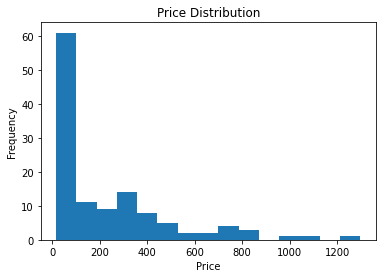

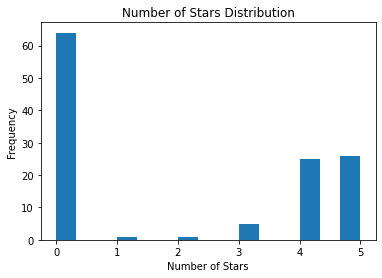

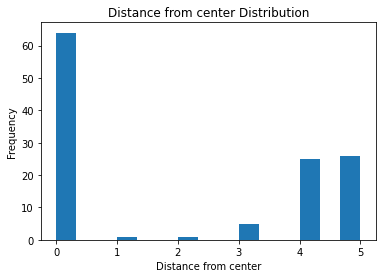

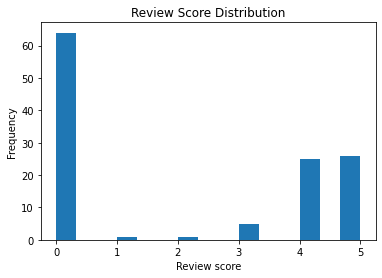

In [67]:
# Step 3: Exploratory Data Analysis (EDA)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

price_df = complete_df[~complete_df.only_price.isnull()].copy()

# Histogram to show distribution for price
plt.title('Price Distribution')
plt.hist(price_df.only_price,bins=15)
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# Histogram to show distribution for number of stars
stars_df = complete_df[~complete_df.number_of_stars.isnull()].copy()

plt.title('Number of Stars Distribution')
plt.hist(stars_df.number_of_stars,bins=15)
plt.xlabel("Number of Stars")
plt.ylabel("Frequency")
plt.show()

# Histogram to show distribution for distance from center
center_distance_df = complete_df[~complete_df.corrected_distance_from_center.isnull()].copy()

plt.title('Distance from center Distribution')
plt.hist(center_distance_df.number_of_stars,bins=15)
plt.xlabel("Distance from center")
plt.ylabel("Frequency")
plt.show()

# Histogram to show distribution for review score
review_score_df = complete_df[~complete_df.corrected_review_score.isnull()].copy()

plt.title('Review Score Distribution')
plt.hist(review_score_df.number_of_stars,bins=15)
plt.xlabel("Review score")
plt.ylabel("Frequency")
plt.show()


                        corrected_review_score  only_price
corrected_review_score                1.000000    0.650171
only_price                            0.650171    1.000000


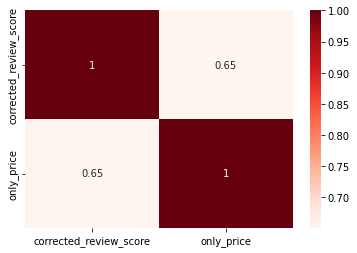

In [68]:
# creating a matrix using review_score and price as rows and columns
print(complete_df[['corrected_review_score', 'only_price']].corr())

# plot the correlation matrix
sns.heatmap(complete_df[['corrected_review_score', 'only_price']].corr(), annot=True, cmap='Reds')
plt.show()

# This shows that the review score and price are positively correlated.

                 number_of_stars  only_price
number_of_stars         1.000000    0.767114
only_price              0.767114    1.000000


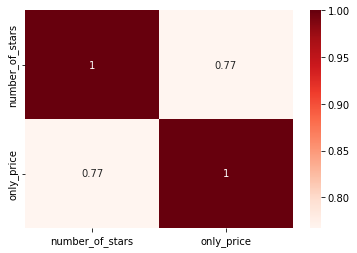

In [69]:
# creating a matrix using number of stars and price as rows and columns
print(complete_df[['number_of_stars', 'only_price']].corr())

# plot the correlation matrix
sns.heatmap(complete_df[['number_of_stars', 'only_price']].corr(), annot=True, cmap='Reds')
plt.show()

# This shows that the number of stars and price are positively correlated.
# Higher the number of stars, higher the price of the accomodation.

                                corrected_distance_from_center  only_price
corrected_distance_from_center                        1.000000   -0.517581
only_price                                           -0.517581    1.000000


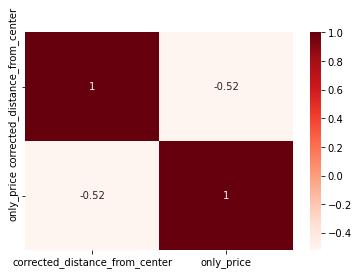

In [70]:
# creating a matrix using distance from center and price as rows and columns
print(complete_df[['corrected_distance_from_center', 'only_price']].corr())

# plot the correlation matrix
sns.heatmap(complete_df[['corrected_distance_from_center', 'only_price']].corr(), annot=True, cmap='Reds')
plt.show()

# This shows that distance from center and price are negatively correlated. 
# So, the less the distance from the center, the higher the price of the accomodation.

In [77]:
# Step 4: Interaction with the user
# inputs: price ranges, distance from city center, number of stars, review_score
# user selects criteria for sorting
# user enters hotel name and gets following information:
# address, distance from city center, average price per night, review_score, hotel rating, hotel summary, 5 photos

# getting the user inputs
min_price = int(input("Enter the minimum price: "))
max_price = int(input("Enter the maximum price: "))
maximum_distance_from_city_center = float(input("Enter the maximum distance from city center: "))
min_number_of_stars = int(input("Enter the minimum number of stars: "))
min_review_score = float(input("Enter the minimum review score: "))
print("The sort categories are: \n\t1. price\n\t2. distance from center\n\t3. number of stars\n\t4. review score")
sort_category = str(input("Enter the sort category: "))

# removing data items that have null values for price, distance, number of stars, and review_score columns
cleaned_df = complete_df[~complete_df.only_price.isnull()].copy()
cleaned_df = cleaned_df[~cleaned_df.corrected_distance_from_center.isnull()].copy()
cleaned_df = cleaned_df[~cleaned_df.number_of_stars.isnull()].copy()
cleaned_df = cleaned_df[~cleaned_df.corrected_review_score.isnull()].copy()
cleaned_df = cleaned_df.astype({"only_price": int, "number_of_stars": int})

# getting the filtered data
output_df = cleaned_df[((cleaned_df['only_price']>=min_price) & \
                        (cleaned_df['only_price']<=max_price) & \
                        (cleaned_df['corrected_distance_from_center']<=maximum_distance_from_city_center) & \
                        (cleaned_df['number_of_stars']>=min_number_of_stars) & \
                        (cleaned_df['corrected_review_score']>=min_review_score))]
if sort_category == 'price':
    output_df = output_df.sort_values(by=['only_price'], ascending=True)

elif sort_category == "distance from center":
    output_df = output_df.sort_values(by=['corrected_distance_from_center'], descending=True)

elif sort_category == "number of stars":
    output_df = output_df.sort_values(by=['number_of_stars'], descending=True)

elif sort_category == "review score":
    output_df = output_df.sort_values(by=["corrected_review_score"], descending=True)

output_df.to_csv("output.csv")
print(json.dumps(output_df.to_dict(orient='records'), indent=4))


Enter the minimum price: 10
Enter the maximum price: 200
Enter the maximum distance from city center: 50
Enter the minimum number of stars: 3
Enter the minimum review score: 3
The sort categories are: 
	1. price
	2. distance from center
	3. number of stars
	4. review score
Enter the sort category: price
[
    {
        "hotel_name": "Generator London",
        "hotel_address": "Camden, London",
        "distance_from_center": "1.3 miles from centre",
        "review_score": "7.0",
        "number_of_stars": 3,
        "total_price": "\u20ac\u00a022",
        "total_nights": 1,
        "hotel_link": "https://www.booking.com/hotel/gb/thegenerator.en-gb.html?label=gen173nr-1FCAQoggJCFnNlYXJjaF9sb25kb24sIGVuZ2xhbmRICVgEaK0CiAEBmAEJuAEYyAEM2AEB6AEB-AEDiAIBqAIEuALKjsKZBsACAdICJDJmMzU5MmVhLWE0NjgtNGUyMy1iZjkxLWVlMGE5OTA1ZGE1YdgCBeACAQ&sid=7e16b5f760bd5bc1f46eecd7f28d882c&aid=304142&ucfs=1&arphpl=1&checkin=2022-11-10&checkout=2022-11-11&group_adults=1&req_adults=1&no_rooms=1&group_children=0&r

Enter hotel name: Generator London
Hotel Name:  Generator London
Distance from city center:  1.3 miles from centre
Average price per night:  € 22
Review score:  7.0
Hotel rating:  3
Hotel summary: In central London in the vibrant area of Bloomsbury, this large, vibrant hostel is near Russell Square Tube Station. The Generator has an internet cafe, a lounge and a games room with pool tables.
The famous Generator Bar has special deals on meals and drinks every night. Entertainment includes karaoke, a live DJ and free movies.
The Generator has dormitory-style shared and private rooms with en suite bathoom. There is a friendly, cosmopolitan atmosphere.
A free walking tour of the city is available.
Hotel photos


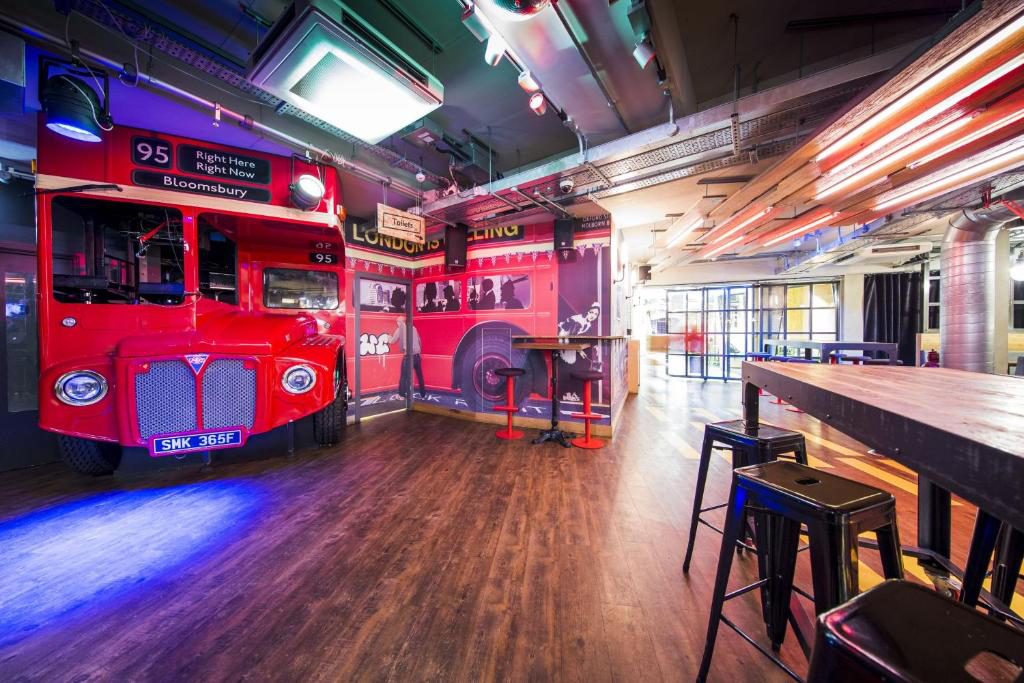

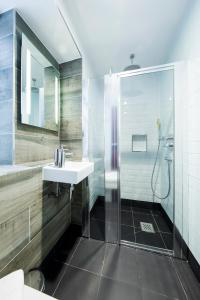

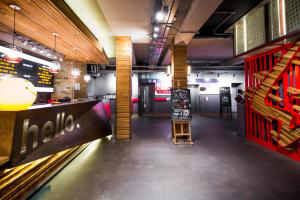

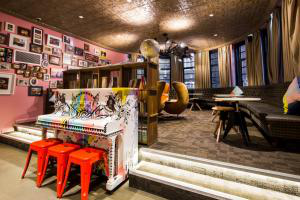

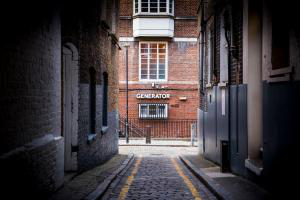

In [73]:
# get user input to return hotel details
"""
Hotels address 
o Distance from city center 
o Average price per night for given accommodation type for the data that you have pre-selected 
o Review score 
o Hotel rating 
o Hotel summary/description 
o At least 5 photos of the hotel 
"""
import io
from PIL import Image
from ast import literal_eval

user_input = str(input("Enter hotel name: ")).lower()

output = cleaned_df[(cleaned_df['processed_hotel_name']==user_input)].iloc[0]
print("Hotel Name: ", output['hotel_name'])
print("Distance from city center: ", output["distance_from_center"])
print("Average price per night: ", output["total_price"])
print("Review score: ", output["review_score"])
print("Hotel rating: ", output["number_of_stars"])
print("Hotel summary:", output["hotel_summary"])
print("Hotel photos")
hotel_images = literal_eval(output["images"])
for image in hotel_images:
    response = requests.get(image) 
    image_bytes = io.BytesIO(response.content)
    img = Image.open(image_bytes)
    display(img) 